# Tunable disordered plasmonic system for structural color generation

Disordered plasmonic nanostructures, known for their broadband absorption, can transition into tunable narrowband reflectors when coupled to a lossless optical cavity. This effect arises from cavity-induced suppression of intrinsic decay in specific optical modes, causing those modes to reflect rather than be absorbed. By varying the spacer thickness, the system can be tuned across the visible spectrum, enabling precise control over optical response. This mechanism offers a simple yet powerful approach to structural color generation, producing vivid and reconfigurable colors without relying on periodic nanostructures or complex fabrication.

This notebook reproduces the key results of this phenomenon based on the work `Mao, P., Liu, C., Song, F. et al. Manipulating disordered plasmonic systems by external cavity with transition from broadband absorption to reconfigurable reflection. Nat Commun 11, 1538 (2020).` [DOI: 10.1038/s41467-020-15349-y](https://doi.org/10.1038/s41467-020-15349-y). The system consists of silver nanoparticles on a LiF spacer layer and a bottom silver mirror. The level of disorder and the spacer thickness can greatly affect the spectral response and color of the system. We will also demonstrate how to convert the reflection spectra to chromaticity coordinates and plot them on a CIE 1913 chromaticity diagram.

<img src="img/disordered_plasmonic_system.png" width="300" alt="Schematic of the disordered plasmonic system">

In [1]:
# library imports
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web

## Simulation Setup

To characterize the color of the disordered plasmonic system, we will simulate the entire visible wavelength range from 380 nm to 780 nm. 

In [2]:
# define frequency and wavelength range
lda0 = 0.58  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(0.38, 0.78, 401)  # wavelength range of interest
freqs = td.C_0 / ldas  # frequency range of interest
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # source bandwidth

The plasmonic nanoparticles and bottom mirror are made of silver. We will use the silver medium from our [material library](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/material_library.html). LiF is characterized by the [Sellmeier](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Sellmeier.html) model with the parameter values extracted from the reference. 

In [3]:
Ag = td.material_library["Ag"]["JohnsonChristy1972"]
LiF = td.Sellmeier(coeffs=[(0.92549, 0.07376**2), (6.96747, 32.79**2)])

In the **ordered** system, the plasmonic nanoparticles have a diameter `d0` of 10 nm. The particles are arranged in a square lattice with an inter-particle spacing of 2 nm. We will investigate an array of 7 by 7 particles. A larger array can be simulated but similar results will be obtained. 

In [4]:
nm = 1e-3

d0 = 10 * nm  # diameter of the nanoparticles before disorder is added
spacing = 2 * nm  # spacing between the particles before disorder is added

Nx = 7  # number of particles in the x direction
Ny = 7  # number of particles in the y direction

# x and y coordinates of the centers of the particles
x0 = np.linspace(0, (Nx - 1) * (d0 + spacing), Nx)
y0 = np.linspace(0, (Ny - 1) * (d0 + spacing), Ny)
Y0, X0 = np.meshgrid(y0, x0)

Disorder is added to the system by adding random variations to the particle diameters and positions. The level of disorder is controlled by the parameter `alpha`, where `alpha=0` corresponds to the perfectly ordered system. A larger `alpha` corresponds to more disorder. Specifically,

$$
d = d_0 \left[1 + \alpha U_1(x, y)\right],
$$

$$
x^i = x_0^i + (\alpha \cdot d_0) U_2(x, y),
$$

$$
y^i = y_0^i + (\alpha \cdot d_0) U_3(x, y),
$$


where $U_1(x, y)$, $U_2(x, y)$, and $U_3(x, y)$ are three independent uniform distributions between -1 and 1. 

In this case, we will focus on `alpha = 0.5` but other disorder levels can be studied in the same way.

In [5]:
alpha = 0.5  # disorder parameter

np.random.seed(1)  # fix a random seed for reproducibility

# adding disorder to the diameters and positions of the particles
d = d0 * (1 + alpha * np.random.uniform(low=-1.0, high=1.0, size=(Nx, Ny)))
X = X0 + (alpha * d0) * np.random.uniform(low=-1.0, high=1.0, size=(Nx, Ny))
Y = Y0 + (alpha * d0) * np.random.uniform(low=-1.0, high=1.0, size=(Nx, Ny))

print(f"The smallest particle diameter is {1e3 * np.min(d):.2f} nm.")

The smallest particle diameter is 5.00 nm.


With the diameters and positions of each particle, we can generate the particle geometries. 

In [6]:
spheres = 0
for x in range(Nx):
    for y in range(Ny):
        spheres += td.Sphere(center=(X[x, y], Y[x, y], d[x, y] / 2), radius=d[x, y] / 2)

disordered_particles = td.Structure(geometry=spheres, medium=Ag)

For excitation, we will add a [PlaneWave](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PlaneWave.html). We will also add a [FluxMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FluxMonitor.html) to measure the reflection spectrum. 

In [7]:
# define a plane wave source
plane_wave = td.PlaneWave(
    center=(0, 0, lda0 / 4),
    size=(td.inf, td.inf, 0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="-",
)

# define a flux monitor to measure reflection
flux_monitor = td.FluxMonitor(
    center=(0, 0, lda0 / 2), size=(td.inf, td.inf, 0), freqs=freqs, normal_dir="+", name="R"
)

The goal is to investigate the reflection spectrum as a function of both wavelength and the spacer layer thickness, which requires us to perform a parameter sweep on different spacer thicknesses. To do so, we define a function `make_sim` that takes the spacer thickness as the input argument and returns a [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html) object.

Usually we recommend leaving at least half a wavelength of spacing between any structures to the PML boundaries to avoid evanescent field from leaking into PML and causing the simulation to diverge. In this case, we recall that the skin depth of silver at the visible range is in the order of 10 nm. Therefore, including more than half a wavelength of silver mirror thickness in the simulation domain is a waste of computation and cost. Instead, we only need to leave about 100 nm of silver mirror. 

Since the nanoparticles can be small, we will need to use a fine grid to resolve them. We use a [MeshOverrideStructure](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.MeshOverrideStructure.html) around the nanoparticle region so the grid size is 2 nm. Outside of the nanoparticle region, we can use a coarse grid to reduce the simulation cost.  

In [8]:
def make_sim(t_spacer):
    # define the spacer layer
    spacer = td.Structure(
        geometry=td.Box(center=(0, 0, -t_spacer / 2), size=(td.inf, td.inf, t_spacer)), medium=LiF
    )

    inf_eff = 1e3  # effective infinity

    # define bottom silver mirror
    mirror = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, -t_spacer)
        ),
        medium=Ag,
    )

    # add a mesh refinement region around the nanoparticles
    refine_box = td.MeshOverrideStructure(
        geometry=td.Box(center=(0, 0, d0), size=(td.inf, td.inf, 2 * d0)),
        dl=[2 * nm, 2 * nm, 2 * nm],
    )

    mirror_thickness = 0.1  # silver mirror thickness to include in the simulation domain

    # simulation domain box
    sim_box = td.Box.from_bounds(
        rmin=(-d0 / 2 - spacing, -d0 / 2 - spacing, -t_spacer - mirror_thickness),
        rmax=((Nx - 0.5) * (d0 + spacing), (Ny - 0.5) * (d0 + spacing), 0.6 * lda0),
    )

    # define simulation
    sim = td.Simulation(
        center=sim_box.center,
        size=sim_box.size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=30, override_structures=[refine_box]),
        run_time=8e-13,
        structures=[disordered_particles, spacer, mirror],
        sources=[plane_wave],
        monitors=[flux_monitor],
        boundary_spec=td.BoundarySpec(
            x=td.Boundary.periodic(),  # set the boundary condition to periodic in x and y
            y=td.Boundary.periodic(),
            z=td.Boundary.pml(),
        ),  # use PML boundary in the z direction
        shutoff=1e-7,  # lower the shutoff level to capture more accurate result
    )

    return sim

To ensure the simulation setup is correct, create a sample simulation and visualize it. We confirm that the simulation setup looks correct.

As expected, we get a warning about structures being to close to the PML boundary even though in this case we don't worry about it.

In [9]:
sim = make_sim(0.15)
sim.plot_3d()

22:07:49 CEST WARNING: Structure: simulation.structures[0] (no `name` was       
              specified) was detected as being less than half of a central      
              wavelength from a PML on side z-min. To avoid inaccurate results  
              or divergence, please increase gap between any structures and PML 
              or fully extend structure through the pml.                        

              WARNING: Suppressed 1 WARNING message.                            

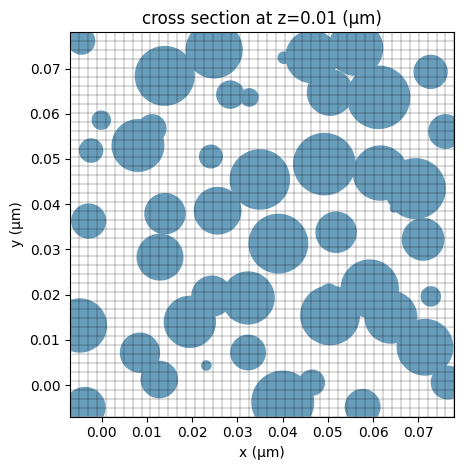

In [10]:
# plot the FDTD grid
ax = sim.plot(z=d0 / 2)
sim.plot_grid(z=d0 / 2, ax=ax)
plt.show()

## Parameter Sweep

Now we are ready to perform the parameter sweep. We will sweep the spacer layer thickness from 50 nm to 300 nm. 

To avoid seeing many warnings from each simulation, we set the logging level to `Error`. 

In [11]:
# change logging level to avoid warning
td.config.logging_level = "ERROR"

t_spacer_list = np.linspace(50 * nm, 300 * nm, 26)

# batch run simulations
sims = {f"t_spacer={t_spacer * 1e3:.0f}nm": make_sim(t_spacer) for t_spacer in t_spacer_list}
batch = web.Batch(simulations=sims)
batch_results = batch.run(path_dir="data")

Output()

22:07:59 CEST Started working on Batch containing 26 tasks.

22:08:23 CEST Maximum FlexCredit cost: 0.821 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

22:08:40 CEST Batch complete.

Output()

## Result Visualization

After the parameter sweep is done, we can extract the reflectance from each simulation and plot them in a 2D false color map. The result reproduces Fig. 2f of the referenced paper. Here we see two reflectance peaks corresponding to the first and second order modes. 

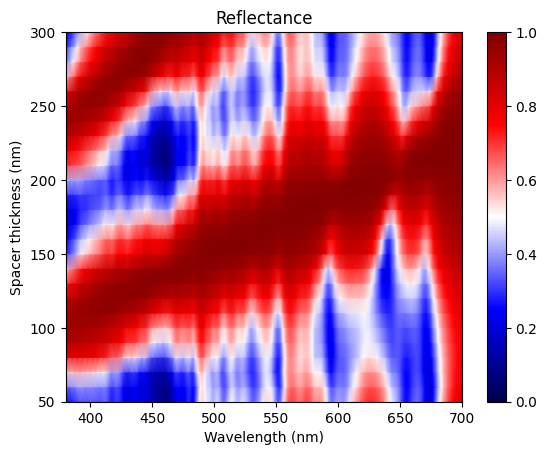

In [12]:
# batch results processing
R_2d = np.array(
    [batch_results[f"t_spacer={t_spacer * 1e3:.0f}nm"]["R"].flux for t_spacer in t_spacer_list]
)

plt.pcolormesh(
    ldas * 1e3, t_spacer_list * 1e3, R_2d, cmap="seismic", shading="gouraud", vmin=0, vmax=1
)
plt.xlim(380, 700)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Spacer thickness (nm)")
plt.title("Reflectance")
plt.colorbar()
plt.show()

Finally, we will calculate the chromaticity coordinates for each spacer layer thickness. One can calculate chromaticity coordinates (CIE 1931 ($x$, $y$)) from a reflection spectrum by simulating how that reflected light would appear under a given illuminant (e.g., D65) and observer color matching functions:

$$
X = \int R(\lambda) S(\lambda) \overline{x}(\lambda) \, d\lambda,
$$
$$
Y = \int R(\lambda) S(\lambda) \overline{y}(\lambda) \, d\lambda,
$$
$$
Z = \int R(\lambda) S(\lambda) \overline{z}(\lambda) \, d\lambda,
$$

$$
x = \frac{X}{X + Y + Z}, \quad y = \frac{Y}{X + Y + Z},
$$

where $ R(\lambda)$ is the reflectance spectrum, $S(\lambda)$ is the spectral power distribution of the illuminant,  $\overline{x}(\lambda)$, $ \overline{y}(\lambda)$, $ \overline{z}(\lambda)$ are the color matching functions. This calculation can be done conveniently by using the Python library [color](https://github.com/colour-science/colour), which can be installed by `pip install colour-science`.

In [13]:
import colour as clr


def reflectance_to_XYZ(ldas, R):
    """
    Convert a reflection spectrum to CIE XYZ tristimulus values.

    Parameters
    ----------
    ldas: Array of wavelengths in microns.
    R: Reflection values corresponding to `ldas`.

    Returns
    -------
    Tristimulus values (X, Y, Z)

    """

    # convert wavelengths from microns to nanometers
    ldas_nm = ldas * 1_000

    # determine spectral sampling interval (assumes uniform spacing)
    step_nm = ldas_nm[1] - ldas_nm[0]

    # define the spectral shape (start, end, interval) for alignment
    shape = clr.SpectralShape(ldas_nm[0], ldas_nm[-1], step_nm)

    # create a spectral distribution object for the reflectance
    sd = clr.SpectralDistribution(dict(zip(ldas_nm, R)), name="reflectance").copy().align(shape)

    # load and align the color matching functions to the same shape
    cmfs = clr.MSDS_CMFS["CIE 1931 2 Degree Standard Observer"].copy().align(shape)

    # load and align the standard illuminant (e.g., D65) to the same shape
    illum = clr.SDS_ILLUMINANTS["D65"].copy().align(shape)

    # compute the tristimulus values (X, Y, Z) from the reflectance, CMFs, and illuminant
    return clr.sd_to_XYZ(sd, cmfs=cmfs, illuminant=illum)


def reflectance_to_xy(ldas, R):
    """
    Convert a reflection spectrum to CIE 1931 chromaticity coordinates (x, y).

    Parameters
    ----------
    ldas: Array of wavelengths in microns.
    R: Reflection values corresponding to `ldas`.

    Returns
    -------
    Chromaticity coordinates (x, y) in the CIE 1931 color space.

    """

    XYZ = reflectance_to_XYZ(ldas, R)

    return clr.XYZ_to_xy(XYZ)  # convert XYZ to chromaticity coordinates (x, y)


# calculate chromaticity for all spectra
chromaticity_xy = np.array([reflectance_to_xy(ldas, R) for R in R_2d])

Finally, we plot the CIE 1931 chromaticity diagram with the sRGB color gamut as a reference. The chromaticity of the disordered plasmonic system is plotted as black dots. 

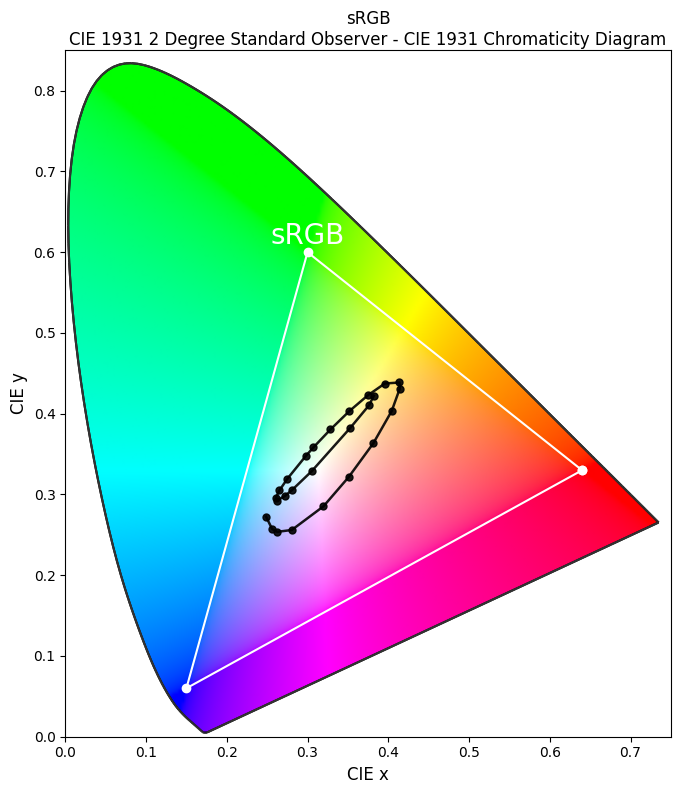

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))

# plot the CIE 1931 chromaticity diagram
clr.plotting.plot_chromaticity_diagram_CIE1931(
    axes=ax,
    show_diagram_colours=True,
    show_spectral_locus=True,
    spectral_locus_colours="black",
    spectral_locus_labels=[],
    show=False,
)

# plot the sRGB color space gamut
clr.plotting.plot_RGB_colourspaces_in_chromaticity_diagram_CIE1931(
    colourspaces=["sRGB"],
    axes=ax,
    show_whitepoints=False,
    plot_kwargs=[{"color": "white", "linestyle": "-", "linewidth": 1.5}],
    spectral_locus_labels=[],
    legend=False,
    show=False,
)

# plot the chromaticity of the disordered plasmonic system
ax.plot(chromaticity_xy[:, 0], chromaticity_xy[:, 1], "-o", c="black", lw=1.8, ms=5, alpha=0.9)

# add text annotation and labels
ax.text(0.3, 0.62, "sRGB", color="white", fontsize=20, ha="center", va="center", zorder=4)
ax.set_xlabel("CIE x", fontsize=12)
ax.set_ylabel("CIE y", fontsize=12)

ax.set_xlim([0, 0.75])
ax.set_ylim([0, 0.85])

plt.show()

Similarly, we can calculate the sRGB values from each spectrum and see how the color actually looks like. 

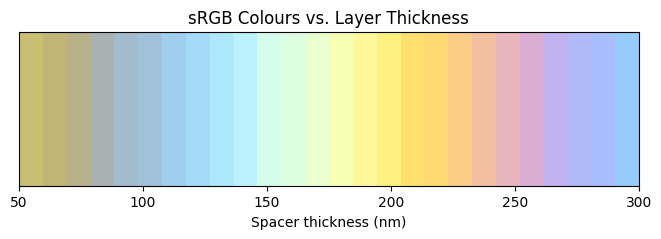

In [15]:
def reflectance_to_sRGB(ldas, R):
    """Convert reflectance to sRGB color (range [0, 1])."""

    XYZ = reflectance_to_XYZ(ldas, R) / 100
    sRGB = clr.XYZ_to_sRGB(XYZ)
    return np.clip(sRGB, 0, 1)


sRGB = np.array([reflectance_to_sRGB(ldas, R) for R in R_2d])

# plot the colors as a function of spacer layer thickness
fig, ax = plt.subplots(figsize=(8, 2))
ax.imshow([sRGB], aspect="auto", extent=[1e3 * t_spacer_list[0], 1e3 * t_spacer_list[-1], 0, 1])
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.set_xlabel("Spacer thickness (nm)")  # or whatever unit you use
ax.set_title("sRGB Colours vs. Layer Thickness")
plt.show()